In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class WeatherPreprocessor:
    def __init__(self):
        # Initial weather features for bike usage
        self.weather_features = [
            "Température de l'air",      
            "Humidité relative",     
            "Visibilité horizontale",       
            "Vitesse du vent",      
            "Précipitations horaires",     
            "Petite_pluie",    
            "Grosse_pluie",
            "Indice_ressenti"    
        ]

	
    def merge_with_bike_data(self, bike_df, weather_df):
        """Merge weather data with bike count data"""
        
        # Round both datetime columns to hours for merging
        bike_df = bike_df.copy()
        bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('h')
        weather_df['date'] = weather_df['date'].dt.floor('h')

        # Merge datasets
        merged_df = pd.merge(
            bike_df,
            weather_df,
            on='date',
            how='left'
        )

        return merged_df

def prepare_features_with_weather(bike_df, weather_df):
    """Prepare complete feature set with weather data"""
    # Initialize preprocessor
    preprocessor = WeatherPreprocessor()

    # Merge and preprocess data
    final_df = preprocessor.merge_with_bike_data(bike_df, weather_df)

    # Select features for modeling
    weather_features = [
        "Température de l'air",      
        "Humidité relative",     
        "Visibilité horizontale",       
        "Vitesse du vent",      
        "Précipitations horaires",     
        "Petite_pluie",    
        "Grosse_pluie",
        "Indice_ressenti"
    ]

    return final_df, weather_features

In [4]:
# Lire le fichier parquet
file_path = "C:/Users/cleme/OneDrive - HEC Paris/Documents/02. Etudes/04. Polytechnique/Cours/01. Data Science with Python/Courses/Projet Final/Work/Working space/bike_counters_ac_team/data/train.parquet"
df = pd.read_parquet(file_path)

# Temporal Analysis
# Convert date to datetime if not already
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

def clean_and_engineer_features(df):
    """
    Clean dataset by removing redundant columns and engineer cyclical features

    Args:
        df: pandas DataFrame containing the bike count data
    Returns:
        DataFrame with cleaned and engineered features
    """
    # Columns to drop
    columns_to_drop = [
        'counter_id',
        'site_id',
        'counter_technical_id',
        'counter_installation_date',
        'coordinates',
        'weekday',  # redundant with day_of_week
        'site_name'  # redundant with counter_name
    ]

    # Drop columns if they exist
    existing_columns = [col for col in columns_to_drop if col in df.columns]
    df = df.drop(columns=existing_columns)

    # Add cyclical encoding for hour (24-hour cycle)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # Add cyclical encoding for month (12-month cycle)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Add cyclical encoding for day_of_week (7-day cycle)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    return df

df = clean_and_engineer_features(df)

#bike_df = df
weather_df = pd.read_csv('Propre_meteo.csv')

weather_df['date'] = pd.to_datetime(weather_df['date'])

# Prepare features
final_df, weather_features = prepare_features_with_weather(df, weather_df)
print(weather_features)
final_df.head()

["Température de l'air", 'Humidité relative', 'Visibilité horizontale', 'Vitesse du vent', 'Précipitations horaires', 'Petite_pluie', 'Grosse_pluie', 'Indice_ressenti']


,counter_name,bike_count,date,latitude,longitude,log_bike_count,hour,day_of_week,month,is_weekend,...,day_of_week_sin,day_of_week_cos,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,Précipitations horaires,Petite_pluie,Grosse_pluie,Indice_ressenti
0,28 boulevard Diderot E-O,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,9,False,...,0.781831,0.62349,12.75,81.0,30000.0,1.6,0.0,0,0,15.47
1,28 boulevard Diderot E-O,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,9,False,...,0.781831,0.62349,10.95,88.0,25000.0,1.1,0.0,0,0,15.22
2,28 boulevard Diderot E-O,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,9,False,...,0.781831,0.62349,10.95,88.0,25000.0,1.1,0.0,0,0,15.22
3,28 boulevard Diderot E-O,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,9,False,...,0.781831,0.62349,20.65,41.0,30000.0,4.0,0.0,0,0,14.65
4,28 boulevard Diderot E-O,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,9,False,...,0.781831,0.62349,19.15,47.0,30000.0,3.0,0.0,0,0,14.65


C:\Users\cleme\AppData\Local\Temp\ipykernel_504\2365228783.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features,


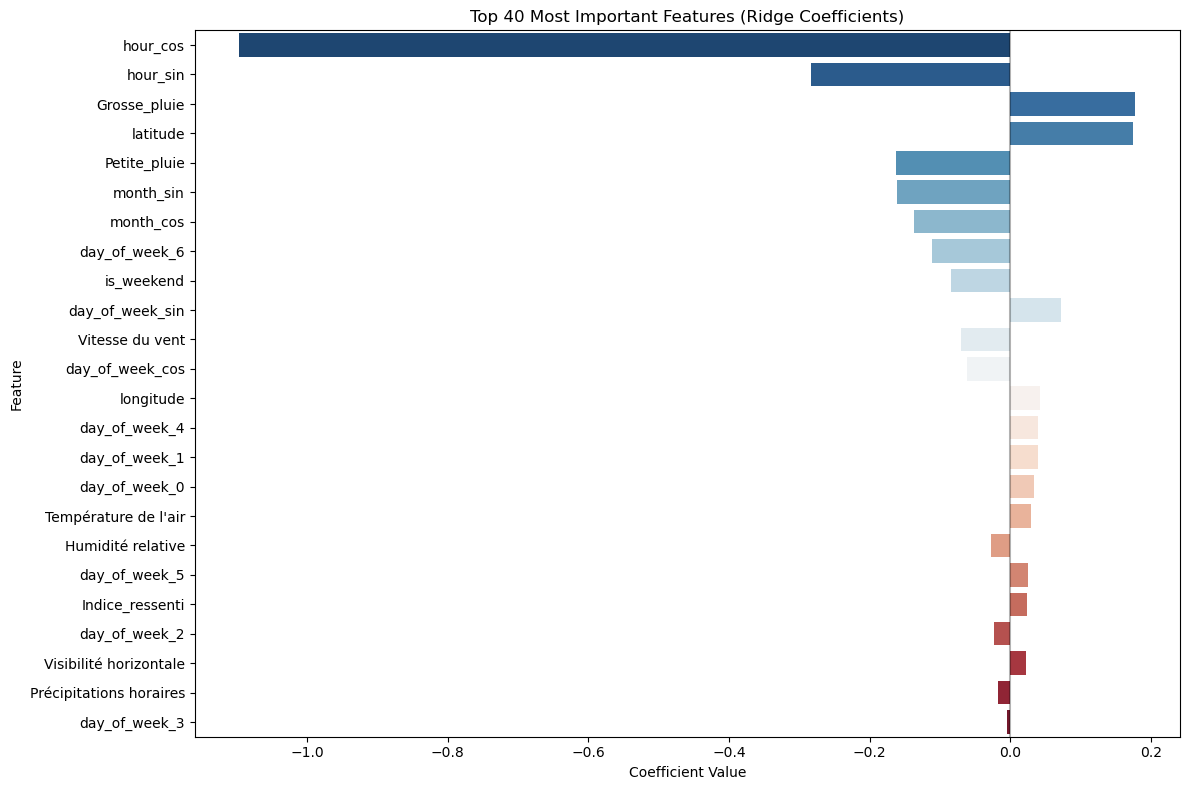

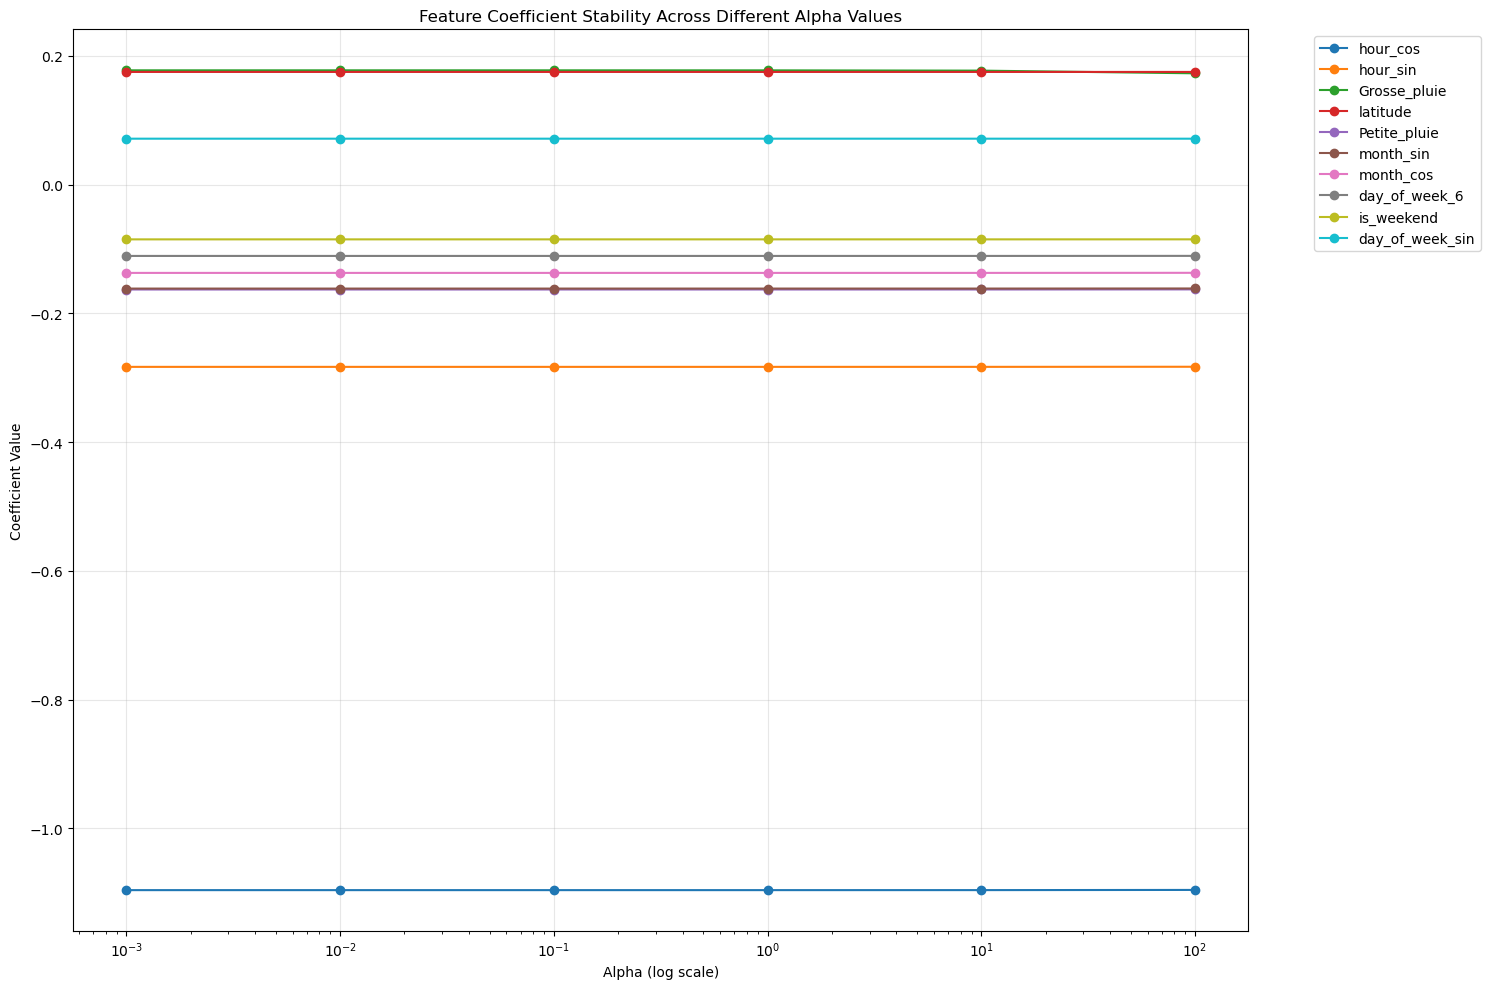


Top 10 Most Important Features (averaged across alphas):
                                                        mean       std
feature                                                               
counter_name_28 boulevard Diderot E-O               2.167490  0.009604
counter_name_Totem 73 boulevard de Sébastopol S-N   1.433927  0.006330
counter_name_Face au 40 quai D'Issy SO-NE           1.432850  0.006418
counter_name_Face au 40 quai D'Issy NE-SO           1.248952  0.005604
counter_name_Totem 73 boulevard de Sébastopol N-S   1.221051  0.005387
counter_name_Totem 64 Rue de Rivoli O-E             1.142282  0.005039
hour_cos                                            1.095848  0.000125
counter_name_67 boulevard Voltaire SE-NO            0.886898  0.003921
counter_name_Face au 4 avenue de la porte de Ba...  0.879497  0.003879
counter_name_27 quai de la Tournelle SE-NO          0.859164  0.003786


In [ ]:
class RidgeFeatureAnalyzer:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos',
            'day_of_week_sin',
            'day_of_week_cos',
            "Température de l'air",
            "Humidité relative",
            "Visibilité horizontale",
            "Vitesse du vent",
            "Précipitations horaires",
            "Indice_ressenti"
            
        ]

        self.binary_features = [
            'is_weekend',
            'Petite_pluie',
            'Grosse_pluie'
        ]

        self.categorical_features = [
            'counter_name',
            'day_of_week'
        ]

    def create_pipeline(self, alpha=1.0):
        """Create preprocessing and Ridge pipeline"""
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge(alpha=alpha))
        ])

    def analyze_feature_importance(self, X, y, alpha=1.0):
        """Analyze feature importance using Ridge regression"""
        # Fit pipeline
        pipeline = self.create_pipeline(alpha=alpha)
        pipeline.fit(X, y)

        # Get feature names after preprocessing
        feature_names = (
            self.numeric_features +
            pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .named_steps['onehot']
            .get_feature_names_out(self.categorical_features).tolist() +
            self.binary_features
        )

        # Get coefficients
        coefficients = pipeline.named_steps['regressor'].coef_

        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        })

        # Sort by absolute coefficient value
        importance_df = importance_df.sort_values('abs_coefficient', ascending=False)

        return importance_df

    def plot_feature_importance(self, importance_df, top_n=40):
        """Plot feature importance"""
        plt.figure(figsize=(12, 8))

        # Plot top N features
        top_features = importance_df[~importance_df['feature'].str.contains('counter_name')].head(top_n)

        # Create bar plot
        sns.barplot(data=top_features,
                   y='feature',
                   x='coefficient',
                   palette='RdBu_r')

        plt.title(f'Top {top_n} Most Important Features (Ridge Coefficients)')
        plt.xlabel('Coefficient Value')
        plt.ylabel('Feature')
        plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_feature_stability(self, X, y, alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
        """Analyze feature importance stability across different alpha values"""
        importance_results = []

        for alpha in alphas:
            importance_df = self.analyze_feature_importance(X, y, alpha=alpha)
            importance_df['alpha'] = alpha
            importance_results.append(importance_df)

        # Combine results
        stability_df = pd.concat(importance_results)

        # Plot stability
        plt.figure(figsize=(15, 10))

        # Get top 10 features by average absolute coefficient
        top_features = (stability_df[~stability_df['feature'].str.contains('counter_name')]
                .groupby('feature')['abs_coefficient']
                .mean()
                .sort_values(ascending=False)
                .head(10)
                .index)

        # Plot coefficient values across alphas for top features
        for feature in top_features:
            feature_data = stability_df[stability_df['feature'] == feature]
            plt.plot(feature_data['alpha'],
                    feature_data['coefficient'],
                    marker='o',
                    label=feature)

        plt.xscale('log')
        plt.xlabel('Alpha (log scale)')
        plt.ylabel('Coefficient Value')
        plt.title('Feature Coefficient Stability Across Different Alpha Values')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return stability_df

# Define feature groups
numeric_features = [
    'latitude',
    'longitude',
    'hour_sin',
    'hour_cos',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    "Température de l'air",
    "Humidité relative",
    "Visibilité horizontale",
    "Vitesse du vent",
    "Précipitations horaires",
    "Indice_ressenti"
]

# Binary features don't need encoding
binary_features = [
    'is_weekend',
    'Petite_pluie',
    'Grosse_pluie'
    ]

# Categorical features need one-hot encoding
categorical_features = [
    'counter_name',
    'day_of_week'  # both cyclic and categorical representation
]

X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

analyzer = RidgeFeatureAnalyzer()

# Basic feature importance analysis
importance_df = analyzer.analyze_feature_importance(X, y, alpha=1.0)
analyzer.plot_feature_importance(importance_df)

# Stability analysis across different alphas
stability_df = analyzer.analyze_feature_stability(X, y)

# Print top 10 most stable features
stability_summary = (stability_df.groupby('feature')['abs_coefficient']
                    .agg(['mean', 'std'])
                    .sort_values('mean', ascending=False)
                    .head(10))